# Investigating RNNs and RL using the N-back cognitive task

**NMA 2023 Group 1 Project**

__Content creators:__ Alan Astudilo, Campbell Border, Disheng, Julia Yin, Koffivi

__Pod TA:__ Suryanarayanan Nagar Anthel Venkatesh

__Project Mentor:__ 

---
# Objective

- 

- 
---

# Project Design
---

# Setup

## Install Dependencies

In [533]:
# @title Install dependencies
%pip install jedi --quiet
%pip install --upgrade pip setuptools wheel --quiet
%pip install numpy==1.23.3 --quiet --ignore-installed
%pip install gymnasium --quiet
%pip install torch --quiet

%pip install matplotlib --quiet
%pip uninstall seaborn -y --quiet
%pip install seaborn --quiet

#!pip install trfl --quiet


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [539]:
# @title Imports

import numpy as np
from numpy.random import default_rng
import gymnasium as gym
from gymnasium import spaces
import torch
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns

## Figure settings

In [537]:
# @title Figure settings
from IPython.display import clear_output, display, HTML
%matplotlib inline
sns.set()

---
# Background

## Replace with our own literature review

- Cognitive scientists use standard lab tests to tap into specific processes in the brain and behavior. Some examples of those tests are Stroop, N-back, Digit Span, TMT (Trail making tests), and WCST (Wisconsin Card Sorting Tests).

- Despite an extensive body of research that explains human performance using descriptive what-models, we still need a more sophisticated approach to gain a better understanding of the underlying processes (i.e., a how-model).

- Interestingly, many of such tests can be thought of as a continuous stream of stimuli and corresponding actions, that is in consonant with the RL formulation. In fact, RL itself is in part motivated by how the brain enables goal-directed behaviors using reward systems, making it a good choice to explain human performance.

- One behavioral test example would be the N-back task.

  - In the N-back, participants view a sequence of stimuli, one by one, and are asked to categorize each stimulus as being either match or non-match. Stimuli are usually numbers, and feedback is given at both timestep and trajectory levels.

  - The agent is rewarded when its response matches the stimulus that was shown N steps back in the episode. A simpler version of the N-back uses two-choice action schema, that is match vs non-match. Once the present stimulus matches the one presented N step back, then the agent is expected to respond to it as being a `match`.


- Given a trained RL agent, we then find correlates of its fitted parameters with the brain mechanisms. The most straightforward composition could be the correlation of model parameters with the brain activities.

## Datasets

- HCP WM task ([NMA-CN HCP notebooks](https://github.com/NeuromatchAcademy/course-content/tree/master/projects/fMRI))

Any dataset that used cognitive tests would work.
Question: limit to behavioral data vs fMRI?
Question: Which stimuli and actions to use?
classic tests can be modeled using 1) bounded symbolic stimuli/actions (e.g., A, B, C), but more sophisticated one would require texts or images (e.g., face vs neutral images in social stroop dataset)
The HCP dataset from NMA-CN contains behavioral and imaging data for 7 cognitive tests including various versions of N-back.

### We need to copy the data and see what's happening

## N-back task

In the N-back task, participants view a sequence of stimuli, one per time, and are asked to categorize each stimulus as being either match or non-match. Stimuli are usually numbers, and feedbacks are given at both timestep and trajectory levels.

In a typical neuro setup, both accuracy and response time are measured, but here, for the sake of brevity, we focus only on accuracy of responses.

---
## Implementation scheme

### Environment
### I am just copying what's on the template to here
The following cell implments N-back envinronment, that we later use to train a RL agent on human data. It is capable of performing two kinds of simulation:
- rewards the agent once the action was correct (i.e., a normative model of the environment).
- receives human data (or mock data if you prefer), and returns what participants performed as the observation. This is more useful for preference-based RL.

In [498]:
# @title Define environment

# N-back environment
class NBack(gym.Env):

    # N = 2
    # step_count =        [ 0  1  2  3  4  5  6 ]
    # sequence =          [ a  b  c  d  a  d  a ]
    # correct actions =   [ ~  ~  0  0  0  1  1 ]

    # actions =           [ ~  ~  1  0  0  1  0 ]
    # reward_class =      [ ~  ~  FP TN TN TP FN]
    # reward =            [ ~  ~  -1  0  0  1 -1]

  # Rewards input is structured as (TP, TN, FP, FN) (positive being matches)
  def __init__(self, N=2, num_targets=None, episode_length=25, rewards=(1, 0, -1, -1), seed=2023):

    self.N = N
    self.num_targets = num_targets
    self.episode_length = episode_length
    self.rewards = rewards
    super().reset(seed=seed)

    # Check that parameters are legal
    assert(episode_length >= N + 1 and episode_length <= 32)

    # Define rewards, observation space and action space 
    self.reward_range = (min(rewards), max(rewards))  # Range of rewards based on inputs
    self.observation_space = spaces.Discrete(10)      # Single variable with 10 possibilities if using digits or 26 if using letters
    self.action_space = spaces.Discrete(2)            # 0 (No match) or 1 (Match)

  def step(self, action):

    # Calculate reward
    if self.step_count >= self.N:
      if (self.correct_actions[self.step_count - self.N]): # Match
        reward = self.rewards[0] if action else self.rewards[3] # TP if matched else FN
      else: # No match
        reward = self.rewards[2] if action else self.rewards[1] # FP if matches else TN
    else:
      reward = None

    # Return next character or None
    self.step_count += 1
    if self.step_count < self.episode_length:
      return self.sequence[self.step_count], self.step_count, reward, False
    else:
      return None, self.step_count, reward, True

  def reset(self, seed=None):

    # Seed RNG
    super().reset(seed=seed)

    # Generate sequence and correct actions
    self._generate_sequence()
    self._get_correct_actions()

    # Observation is first character
    self.step_count = 0
    observation = self.sequence[self.step_count]

    return observation, self.step_count, None, False
  
  def _generate_sequence(self):

    # Generate sequence of length self.episode_length (with correct number of targets)
    while True:

      self.sequence = np.random.randint(0, 9, size=(self.episode_length))
      if not self.num_targets or sum(self._get_correct_actions()) == self.num_targets:
        break;

      # positions = np.arange(2, self.episode_length)
      # match_positions = self.np_random.choice(positions, size=self.num_targets)
      # match_positions = np.concatenate((match_positions, match_positions - self.N))
      # print(match_positions)
      # self.sequence = np.ones(self.episode_length)
      
  def _get_correct_actions(self):
    self.correct_actions = np.array([int(self.sequence[i] == self.sequence[i + self.N]) for i in range(self.episode_length - self.N)])
    return self.correct_actions

  def get_correct_action(self):
    return self.correct_actions[self.step_count - 1]

In [ ]:
# @title Test environment

# env = NBack()
# print(f"First char is {env.reset()[0]}")
# print(env.sequence)
# print(env.correct_actions)
# for i in range(16):
#   print(env.step(i % 2))

env = NBack(num_targets=5)
env.reset()
print(env.sequence)
print(env.correct_actions)
print(sum(env.correct_actions))


### Define a random agent

In [ ]:
## please write your code for random agents here

# Random agent
class RandomAgent(nn.Module):
    
    

### Define a simple Q-learning agent

### Define a Recurrent Deep Q-learning Agent (RDQN)

# Section 4: Model(s)

In [647]:
# Random agent
class RandomAgent(nn.Module):
    
    def __init__(self, env):
        super().__init__()
        self.env = env

    def choose_action(self, char):

        # Choose match/no match randomly
        return np.random.randint(0, 2)

    def test(self, num_episodes):
        
        tp_percent = np.zeros(num_episodes)
        fp_percent = np.zeros_like(tp_percent)
        fn_percent = np.zeros_like(tp_percent)

        for i in range(num_episodes):

            actions = np.zeros(self.env.episode_length, dtype=int)
            char, step_count, reward, done = self.env.reset()

            while char is not None:
                action = self.choose_action(char)
                actions[step_count] = action
                char, step_count, reward, done = self.env.step(action)
            
            # Get episode data
            actions = actions[self.env.N:]
            correct_actions = self.env.correct_actions
            tp_percent[i] = np.dot(actions, correct_actions) #/ sum(correct_actions)
            fp_percent[i] = np.dot(actions, 1 - correct_actions) #/ sum(1 - correct_actions)
            fn_percent[i] = np.dot(1 - actions, correct_actions) #/ sum(correct_actions)

        return tp_percent, fp_percent, fn_percent

        

SyntaxError: unexpected EOF while parsing (3220473413.py, line 4)

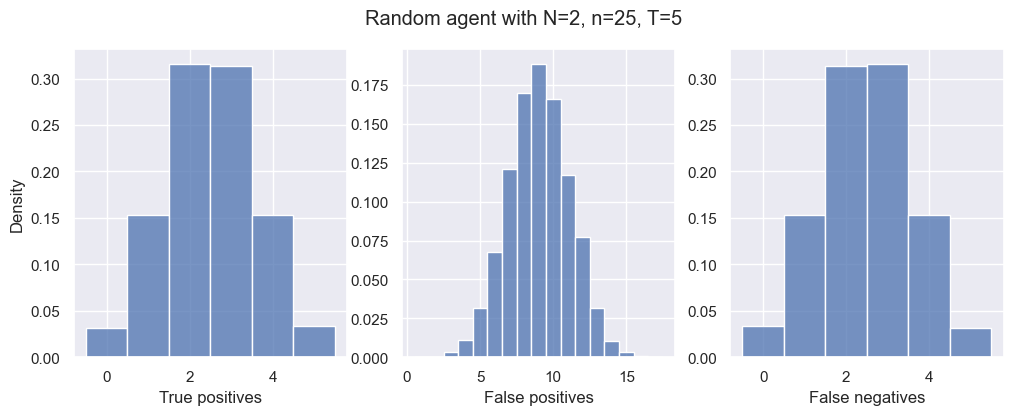

In [651]:
# @title Test random agent
# Create environment, random agent and test
N = 2
n = 25
T = 5
env = NBack(N=2, episode_length=n, num_targets=T)
agent = RandomAgent(env=env)
results = agent.test(10000)

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
fig.suptitle(f"Random agent with N={env.N}, n={env.episode_length}, T={env.num_targets}")
sns.histplot(results[0], stat="density", bins=4, discrete=True)
plt.xlabel('True positives')

plt.subplot(1, 3, 2)
sns.histplot(results[1], stat="density", bins=17, discrete=True)
plt.xlabel('False positives')
plt.ylabel('')

plt.subplot(1, 3, 3)
sns.histplot(results[2], stat="density", bins=4, discrete=True)
plt.xlabel('False negatives')
plt.ylabel('')
plt.show()

In [ ]:
# RNN

class SimpleRNN(nn.Module):
    
    def __init__(self):
        super().__init__()